# Description
*author:* Vina My Pham<br>
*supervisor:* Robin van der Weide<br>
*project:* MSc internship project<br>
<br>
*date:* January 15 - July 26, 2024<br>
*host:* Kind group, Hubrecht Institute<br>
*university:* Bioinformatics, Wageningen University & Research<br>

---

Notebook to detect overlapping masks in Z-direction.

---
**Input**<br>
- `img_stack_path`: Path to the 3D image matrix (TIFF; Z * X * Y * channels)
- `matrix_stack_path`: Path to the 3D label matrix (TIFF) (TIFF; Z * X * Y )

> *Multiple stacks can be provided for batch runs.*

- `neighbour_range`: Range of the neighbour planes to check. (e.g. if `neighbour_range = 2`, then for *plane i*, the masks in *plane i + 1*, *i + 2* AND *i - 1*, *i - 2*, will be considered.)
---
**Output**

- `overlap_range<neighbor_range>_<sample_name>.csv`
columns:
        0. main_mask_id: ID of the main mask.
        1. main_plane_id: Plane index of the main mask.
        2. main_mask_size: Number of pixels in the main mask.
        3. overlap_mask_id: ID of the overlapping mask.
        4. overlap_plane_id: Plane index of the overlapping mask.
        5. overlap_mask_size: Number of pixels in the overlapping mask.
        6. intersection_size: Number of pixels in the intersection of
            the main and overlapping masks.
        7. union_size: Number of pixels in the union of the main and
            overlapping masks.
        8. ratio_overlap_in_main: Ratio of overlapping mask size to main
            mask size.
        9. jaccard_index: Jaccard index calculated between the main and
            overlapping masks.
        10. dice_coefficient: Dice coefficient calculated between the
            main and overlapping masks.


# Notebook initialisation

## pip install

In [ ]:
#!pip install cellpose==2.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.7/171.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━ 30.9/56.5 MB 5.5 MB/s eta 0:00:05
ERROR: Operation cancelled by user


## imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount=True)

from datetime import datetime
import copy

import numpy as np
import pandas as pd
from IPython.display import display

import cv2
import skimage.io
import matplotlib.pyplot as plt
import tifffile

#from cellpose.utils import outlines_list()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## custom functions

### data storage

In [ ]:
#@markdown [classes]
class Stack:
    """A class representing a 3D stack with associated metadata.

    Attributes:
        name (str): The name of the 3D stack
        img_path (str): The file path to the images of 3D stack
        mask_path (str): The file path to the masks of 3D stack
        img_matrix (numpy.ndarray): The image matrix of the 3D stack
        mask_matrix (numpy.ndarray): The mask matrix of the 3D stack
        nplanes (int): The number of planes in the 3D stack
        nchannels (int): The number of channels in the 3D stack
        nmasks (int): The number of masks in the 3D stack
    Notes:
        uses modules skimage.io, matplotlib.pyplot, copy
    """
    def __init__(self, name, img_path, mask_path):
        self.name = name
        self.img_path = img_path
        self.mask_path = mask_path
        self.img_matrix = None
        self.mask_matrix = None
        self.nplanes = None
        self.nchannels = None
        self.nmasks = None

        self.load_data()

    def load_data(self):
        """Load the stack image and masks from the input paths"""
        img_matrix = skimage.io.imread(self.img_path)
        mask_matrix = skimage.io.imread(self.mask_path)

        #check if n planes, x, y are the same
        if img_matrix.shape[:-1] != mask_matrix.shape:
            raise IOError("Dimensions of provided stack " +
                          f"{img_matrix.shape[:-1]} does not correspond " +
                          f"with provided masks {mask_matrix.shape}.")

        self.img_matrix = img_matrix
        self.mask_matrix = mask_matrix

        self.nplanes = self.img_matrix.shape[0]
        self.nchannels = self.img_matrix.shape[-1]
        self.nmasks = len(self.mask_ids())

    def mask_ids(self, iplane = None):
        """

        Returns:
            if iplane=False: all mask ids in the entire stack are returned
            if iplane=int: mask ids present in that plane are returned
        """
        if isinstance(iplane, int):
            mask_ids = list(np.unique(self.mask_matrix[iplane,:,:]))
            mask_ids.remove(0)

        else:
            mask_ids = list(np.unique(np.concatenate([self.mask_ids(i) for i in range(self.nplanes)])))

        return mask_ids

    def plot(self, iplane, mask_id=False, channel=1, plot_outlines=True, outline_color='r', figsize=(10,10), save=False):
        """
        mask_id (False, or int): if False or 0, all masks will be plotted. Else a specific mask under that id will be plotted.
        """
        fig = plt.figure(figsize=figsize)
        plt.imshow(self.img_matrix[iplane,:,:,channel], cmap=plt.cm.gray)
        plt.title(f"plane {iplane}" +
                 (f" (mask {mask_id})" if mask_id else ""))
        plt.axis("off")

        if plot_outlines:
            mask = copy.deepcopy(self.mask_matrix[iplane, :, :])

            if mask_id: #only plot specified mask
                if mask_id not in mask:
                    raise ValueError(f"No mask with mask_id={mask_id} present")

                mask[~np.isin(mask,[mask_id])] = 0

            for o in outlines_list(mask):
                plt.plot(o[:,0], o[:,1], color=outline_color)

        if save: plt.savefig(save)

        plt.show();

        return fig

    dictionary
        key: reference_id
        value: dict - key: direction
                      val: dict - key: comp_id
                                  val: jaccard

### data processing

In [ ]:
def find_overlap_in_z(label_matrix, neighbor_range):
    """Find overlapping masks in Z-Neighboring and Z+ neighboring planes

    Args:
        label_matrix (np.ndarray): 3D label matrix, where each unique int is a
                                   label
        neighbor_range (int): Number of neighboring planes to consider above
                              and below each mask's plane.

    Returns:
        pd.DataFrame: A DataFrame containing information about overlapping
            masks in the neighboring planes. Columns include:
            0. main_mask_id: ID of the main mask.
            1. main_plane_id: Plane index of the main mask.
            2. main_mask_size: Number of pixels in the main mask.
            3. overlap_mask_id: ID of the overlapping mask.
            4. overlap_plane_id: Plane index of the overlapping mask.
            5. overlap_mask_size: Number of pixels in the overlapping mask.
            6. intersection_size: Number of pixels in the intersection of
                the main and overlapping masks.
            7. union_size: Number of pixels in the union of the main and
                overlapping masks.
            8. ratio_overlap_in_main: Ratio of overlapping mask size to main
                mask size.
            9. jaccard_index: Jaccard index calculated between the main and
                overlapping masks.
            10. dice_coefficient: Dice coefficient calculated between the
                main and overlapping masks.
    """
    data_list = []
    compared_pairs = set()

    main_mask_ids = list(np.unique(label_matrix))
    if 0 in main_mask_ids:
        main_mask_ids.remove(0)

    for main_mask_count, main_mask_id in enumerate(main_mask_ids):

        #get neighbor planes
        mask_iplanes = get_iplanes(label_matrix, main_mask_id)
        #print(f'mask_id: {main_mask_id}\tplane_id:{mask_iplanes}')

        #z- direction
        bottom_mask_iplane = mask_iplanes[0]
        bottom_neighbor_iplanes = list(range(bottom_mask_iplane-(neighbor_range), bottom_mask_iplane))
        bottom_neighbor_iplanes = [iplane for iplane in bottom_neighbor_iplanes
                                  if iplane >= 0]

        #z+ direction
        top_mask_iplane = mask_iplanes[-1]
        top_neighbor_iplanes = list(range(top_mask_iplane+1, top_mask_iplane+(neighbor_range+1))) #account for off-by-one
        top_neighbor_iplanes = [iplane for iplane in top_neighbor_iplanes
                               if iplane < label_matrix.shape[0]]

        #detect overlapping masks in neighbour planes
        #get regions to search in
        top_mask_px = get_mask_px_coords(label_matrix[top_mask_iplane, :, :], main_mask_id)
        bottom_mask_px = get_mask_px_coords(label_matrix[bottom_mask_iplane, :, :], main_mask_id)

        #print("\tiplane\timask")
        for main_plane_id, main_mask_px, neighbor_iplanes in ((bottom_mask_iplane, bottom_mask_px, bottom_neighbor_iplanes),
                                                              (top_mask_iplane, top_mask_px, top_neighbor_iplanes)):
            #calculate metrics
            for iplane in neighbor_iplanes:
                ids_in_neighbor_iplane = get_mask_ids_from_coords(label_matrix[iplane, :, :], main_mask_px)
                #print('\t',iplane,'\t',ids_in_neighbor_iplane)

                for overlap_mask_id in ids_in_neighbor_iplane:

                    #only consider pairs that havent been checked yet.
                    #i.e. check (A,B), skip (B,A)
                    pair = tuple(sorted((main_mask_id, overlap_mask_id)))
                    if pair in compared_pairs:
                        continue  # Skip if this pair has already been compared
                    compared_pairs.add(pair)

                    overlap_mask_px = get_mask_px_coords(label_matrix[iplane, :, :], overlap_mask_id)

                    intersection_px, union_px, jaccard_index = calculate_jaccard(main_mask_px, overlap_mask_px)
                    dice_coefficient = (2 * len(intersection_px)) / (len(main_mask_px) + len(overlap_mask_px))

                    data = {"main_mask_id": main_mask_id,
                            "main_plane_id": main_plane_id,
                            "main_mask_size": len(main_mask_px) ,
                            "overlap_mask_id": overlap_mask_id,
                            "overlap_plane_id": iplane,
                            "overlap_mask_size": len(overlap_mask_px),
                            "intersection_size": len(intersection_px),
                            "union_size": len(union_px),
                            "ratio_overlap_in_main": len(intersection_px)/len(main_mask_px),
                            "ratio_main_in_overlap": len(intersection_px)/len(overlap_mask_px),
                            "jaccard_index": jaccard_index,
                            "dice_coefficient": dice_coefficient}

                    data_list.append(data)

    df = pd.DataFrame(data_list)
    return df

### analysis

In [ ]:
def calculate_jaccard(reference_list, compare_list):
    """Calculate Jaccard index between two sets of coordinates.

    Args:
        reference_list (list): np.array of arrays - coordinates for reference
        compare_list (list): np.array of arrays - coordinates for comparison

    Returns:
        0. list of tuples: Tuples both lists have in common (intersection)
        1. list of tuples: All unique tuples in both lists (union)
        2. list of floats: Jaccard index (intersection/union)
    """
    reference_tuples = list(map(tuple, reference_list))
    compare_tuples = list(map(tuple, compare_list))
    intersection = set(reference_tuples).intersection(set(compare_tuples))
    union = set(reference_tuples).union(set(compare_tuples))
    jaccard = len(intersection) / len(union)
    return intersection, union, jaccard

### helper

In [ ]:
def get_iplanes(mask_matrix, mask_id):
    """Get planes in which the mask id is present in a 3D matrix

    Args:
        mask_matrix (numpy.ndarray): 3D mask matrix
        mask_id (int): ID of the mask to search for

    Returns:
        list of ints - plane indices where the mask is present, sorted in
                       ascending order
    """
    planes = []
    for iplane in range(mask_matrix.shape[0]):
        if mask_id in mask_matrix[iplane,:,:]:
            planes.append(iplane)
    return sorted(planes)

def get_mask_px_coords(mask_matrix, mask_id):
    """Get pixel coordinates with specified mask ID in a 2D/3D matrix

    Args:
        mask_matrix (numpy.ndarray): mask matrix of one plane or a full stack
            2D shape: nY x nX
            3D shape: nPlanes x nY x nX
        mask_id (int): ID of the mask to retrieve pixel coordinates.

    Returns:
        numpy.ndarray: Array of pixel coordinates where the mask is present
            nested arrays of 2 elements (or 3 if 3D) - 2D: (Y, X)
                                                       3D: (plane id, Y, X)
    """
    mask = copy.deepcopy(mask_matrix)
    mask[~np.isin(mask,[mask_id])] = 0
    return np.transpose(np.nonzero(mask))

def get_mask_ids_from_coords(plane_mask_matrix, px_coords, unique=True):
    """Get unique mask IDs from specified pixel coordinates in a 2D matrix

    Args:
        2d_plane_mask_matrix (numpy.ndarray): 2D mask matrix of a single plane
        px_coords (list): list of pixel coordinates
        unique (bool, optional): if True, retain unique ids;
                                 if False, duplicates are included
                                 Default: True

    Returns:
        list - mask IDs at the specified pixel coordinates.
    """
    mask_ids = np.array([plane_mask_matrix[px_coord[0], px_coord[1]]
                         for px_coord in px_coords])
    mask_ids = list(mask_ids[mask_ids != 0])
    if unique:
        mask_ids = list(np.unique(mask_ids))
    return mask_ids

### temporary (remove later?)

In [ ]:
#utils
def outlines_list(mask_matrix):
    """ get outlines of masks as a list to loop over for plotting

    Notes:
        outlines_list() cellpose v2.2.2
    """
    print("DEV: REMOVE outlines_list def FROM FINAL. USE outlines_list from " +
          "cellpose.utils import")
    outline_px =[]

    mask_ids = list(np.unique(mask_matrix))
    if 0 in mask_ids:
        mask_ids.remove(0)

    for mask_id in mask_ids:
        mask_px = mask_matrix == mask_id
        contours = cv2.findContours(mask_px.astype(np.uint8),
                                    mode=cv2.RETR_EXTERNAL,
                                    method=cv2.CHAIN_APPROX_NONE)[-2]

        cmax = np.argmax([c.shape[0] for c in contours])
        pix = contours[cmax].astype(int).squeeze()
        if len(pix)>4:
            outline_px.append(pix)
        else:
            outline_px.append(np.zeros((0,2)))
    return outline_px

# Input data

**User input**
- `stack_name`
- `img stack path` (img shape: nPLanes x nY x nX x nChannels)
- `matrix stack path` (mask shape: nPLanes x nY x nX)



Object created (`stack_data`).
name:	SPE_20240216_D35
number of planes:	28
number of channels:	3
number of masks:	942

Preview: slice 14, including outlines
DEV: REMOVE outlines_list def FROM FINAL. USE outlines_list from cellpose.utils import


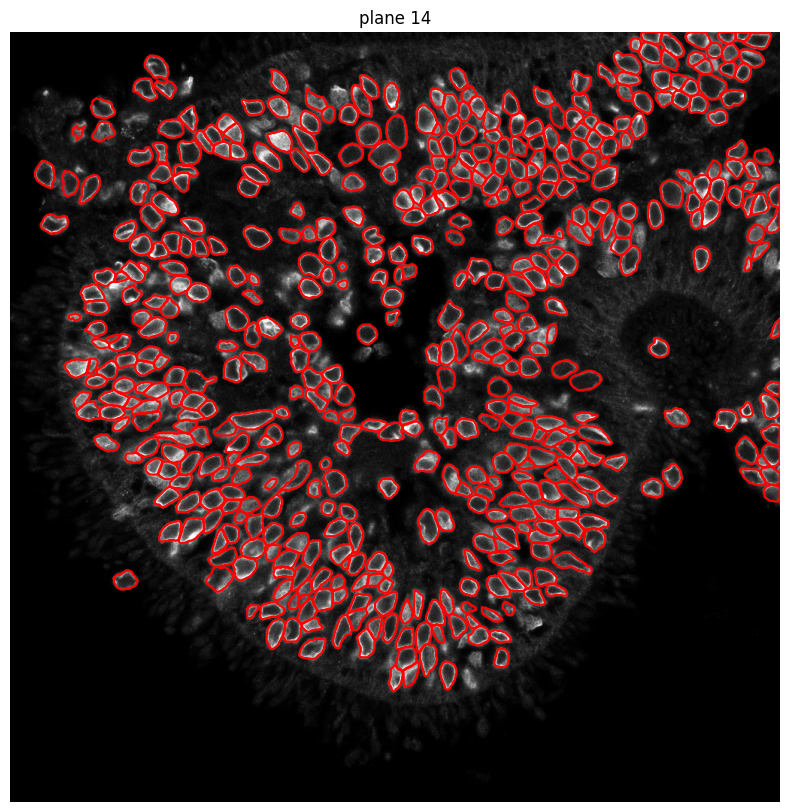

In [ ]:
stack_name = "SPE_20240216_D35" #@param {type:"string"}
img_stack_path = "/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/00_raw_data/full_zstacks/SPE_20240216_D35.tif" #@param {type:"string"}
mask_stack_path = "/content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/04_cellpose3D/SPE_20240216_D35/anisotropy-0.77/3D_masks_mode-stitched2dmasks.tiff" #@param {type:"string"}

stack_data = Stack(stack_name, img_stack_path, mask_stack_path)
print("Object created (`stack_data`)." +
      f"\nname:\t{stack_data.name}" +
      f"\nnumber of planes:\t{stack_data.nplanes}" +
      f"\nnumber of channels:\t{stack_data.nchannels}" +
      f"\nnumber of masks:\t{stack_data.nmasks}")

#show middle slice
iplane=round(stack_data.nplanes/2)
print(f"\nPreview: slice {iplane}, including outlines")
_ = stack_data.plot(iplane, channel=1)
plt.show();

try:
    stack_data_list.append(stack_data)
except NameError:
    stack_data_list = [stack_data]

## Bulk mode: show loaded data

In [ ]:
print("name\timg_path\tmask_path")
for idx, obj in enumerate(stack_data_list):
    print(obj.name, obj.img_path, obj.mask_path)

name	img_path	mask_path
SPE_20230327_D25 /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/00_raw_data/full_zstacks/SPE_20230327_D25.tif /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/04_cellpose3D/SPE_20230327_D25/anisotropy-4.17/3D_masks_mode-stitched2dmasks.tiff
SPE_20230327_D30 /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/00_raw_data/full_zstacks/SPE_20230327_D30.tif /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/04_cellpose3D/SPE_20230327_D30/anisotropy-4.17/3D_masks_mode-stitched2dmasks.tiff
SPE_20230327_D35 /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/00_raw_data/full_zstacks/SPE_20230327_D35.tif /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/04_cellpose3D/SPE_20230327_D35/anisotropy-5.56/3D_masks_mode-stitched2dmasks.tiff
SPE_20230327_D40 /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/00_raw_data/full_zstacks/SPE_20230327_D40.tif /content/gdrive/MyDrive/msc-internship_HI_2024_vmp/02_results/04_cellpose3D/SPE_20230327

# Show outlines
everything seems a little shifted to the bottom right.
for simple foci counting this is not a problem, but once we analyse the intensity, we should fix this.


Preview: slice 0, including outlines
DEV: REMOVE outlines_list def FROM FINAL. USE outlines_list from cellpose.utils import


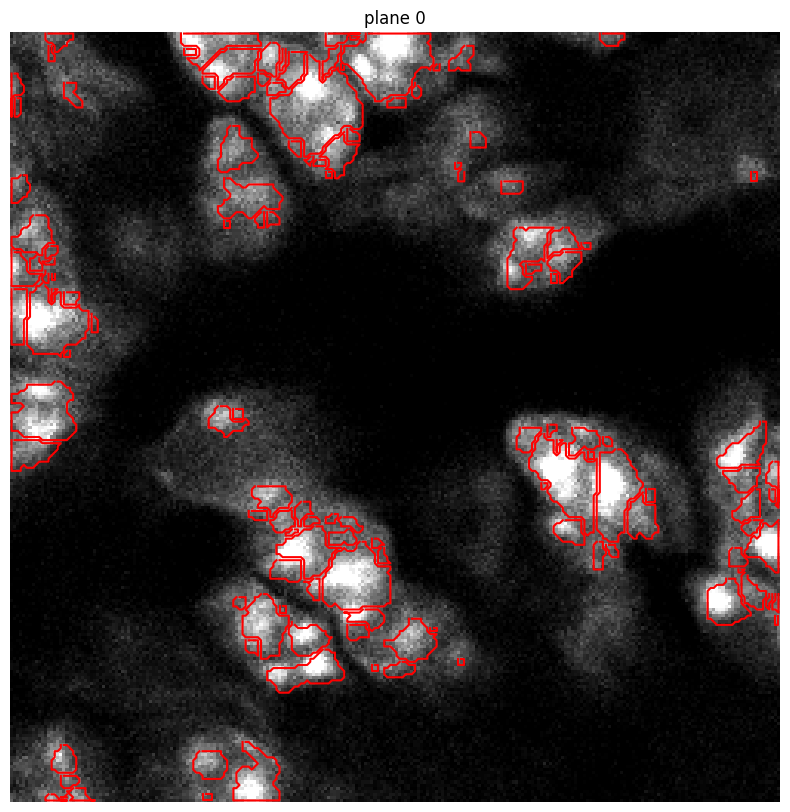


Preview: slice 1, including outlines
DEV: REMOVE outlines_list def FROM FINAL. USE outlines_list from cellpose.utils import


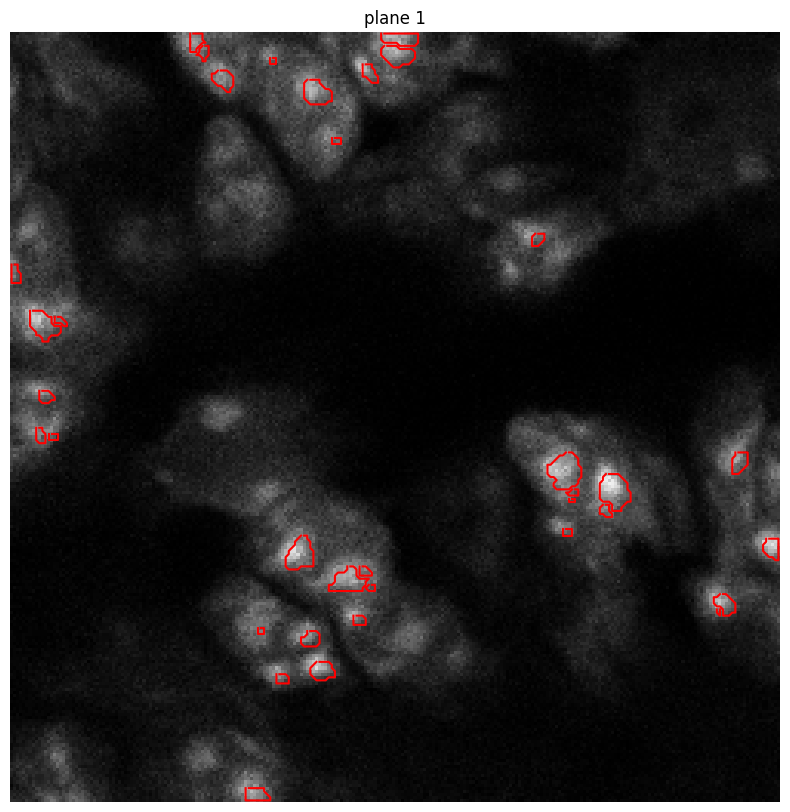


Preview: slice 2, including outlines
DEV: REMOVE outlines_list def FROM FINAL. USE outlines_list from cellpose.utils import


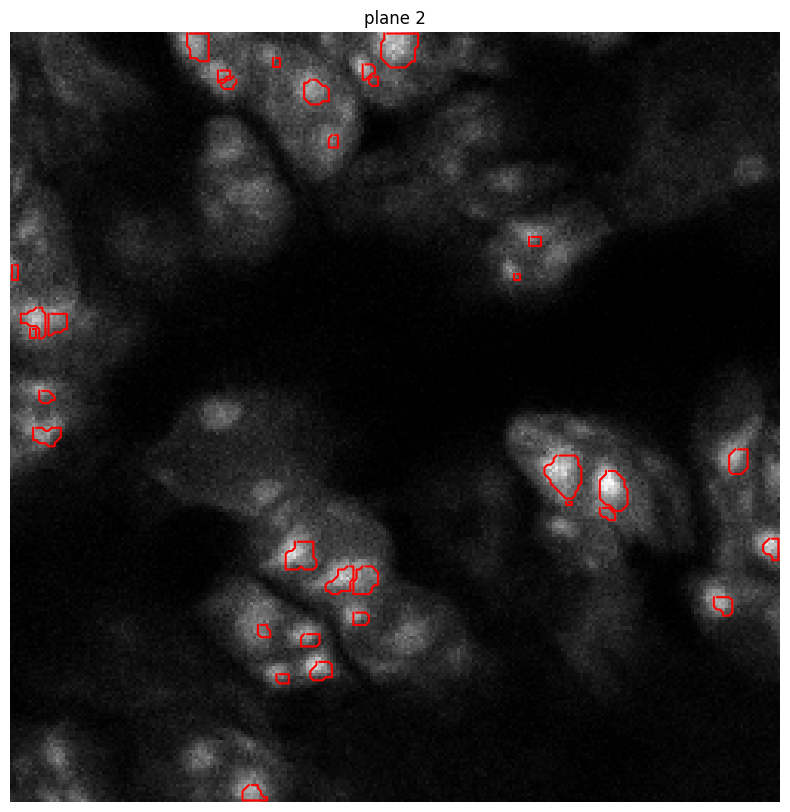


Preview: slice 3, including outlines
DEV: REMOVE outlines_list def FROM FINAL. USE outlines_list from cellpose.utils import


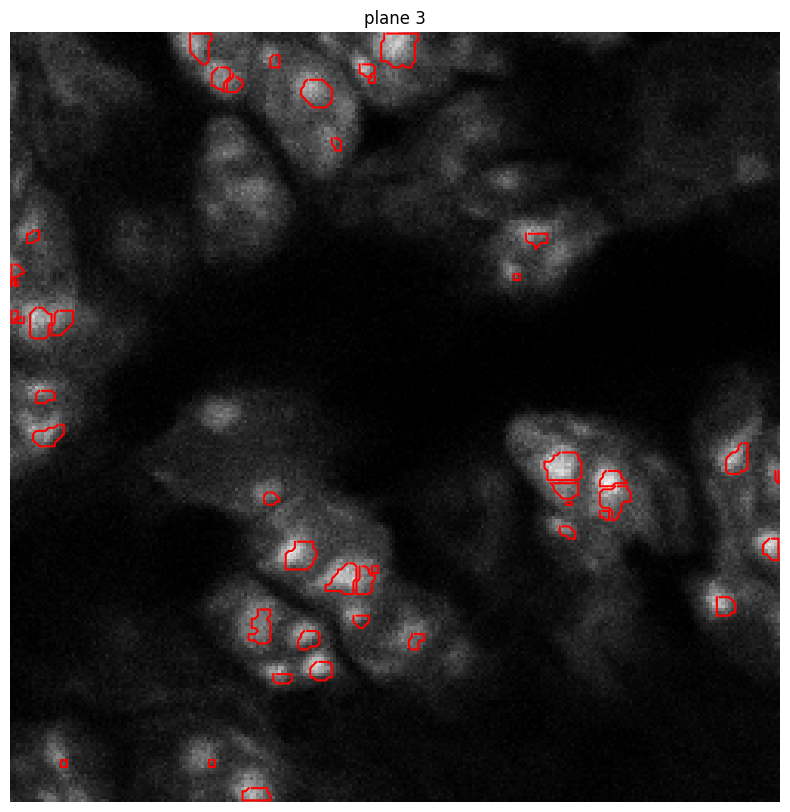

In [ ]:
iplanes=[0,1,2,3]
ichannel=0

for iplane in iplanes:
    print(f"\nPreview: slice {iplane}, including outlines")
    _ = stack_data.plot(iplane, channel=ichannel)

# Find overlapping masks

**input**<br>
`stack_data_list`: list of loaded StackObjects

**output**<br>
for each loaded data: `overlap_range{neighbour_range}_{stack_data.name}.csv`<br><br>
**NOTE: the files are saved in the session storage and will be deleted when runtime is disconnected.**

In [ ]:
 neighbour_range = 4
 for stack_data in stack_data_list:
    print(f"{datetime.now()}\tProcessing {stack_data.name} with range = {neighbour_range}")

    overlap_df = find_overlap_in_z(label_matrix = stack_data.mask_matrix,
                                neighbor_range = neighbour_range)

    print(f"{datetime.now()}\tFinished processing {stack_data.name}")

    #save file
    overlap_df.to_csv(f'overlap_range{neighbour_range}_{stack_data.name}.csv', index=False)


    #display(overlap_df)

2024-04-18 13:05:21.190966	Processing SPE_20230327_D25 with range = 4
2024-04-18 13:06:46.806789	Finished processing SPE_20230327_D25
2024-04-18 13:06:46.836631	Processing SPE_20230327_D30 with range = 4
2024-04-18 13:08:08.929282	Finished processing SPE_20230327_D30
2024-04-18 13:08:08.951883	Processing SPE_20230327_D35 with range = 4
2024-04-18 13:09:19.940558	Finished processing SPE_20230327_D35
2024-04-18 13:09:19.955647	Processing SPE_20230327_D40 with range = 4
2024-04-18 13:10:18.029266	Finished processing SPE_20230327_D40
2024-04-18 13:10:18.042332	Processing SPE_20240216_D35 with range = 4
2024-04-18 13:10:56.027811	Finished processing SPE_20240216_D35
